# Agent for epidemic control model  
This notebook will train an agent in an epidemic control environment using DDPG with RNNs.  
  
For use, please edit PATH variable below to any folder where training outputs can be stored.  
Also, please create a folder titled 'policy' in PATH directory.  


In [1]:
PATH = '/home/jovyan/Masterarbeit/Agent'

## Imports

Firstly, all relevant dependencies will be imported.  
Comments indicate what imports are generally used for or related to.

In [2]:
import sys

import tensorflow as tf 
import numpy as np

# Environment 
from tf_agents.environments import tf_py_environment
from tf_agents.environments import py_environment
from tf_agents.policies import scripted_py_policy
from tf_agents.policies import random_tf_policy
# Neural Networks
from tf_agents.agents.ddpg import actor_rnn_network
from tf_agents.agents.ddpg import critic_rnn_network
from tf_agents.networks import sequential
from tf_agents.networks import nest_map
from tf_agents.keras_layers import inner_reshape
import functools
# Agent 
from tf_agents.agents.ddpg import ddpg_agent
# Experience Replay
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
#Training
from tf_agents.utils import common
#Evaluation
from tf_agents.policies import policy_saver
from tf_agents.trajectories import time_step
import os
import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')


## Environment

Next, an environment will be imported and initialized.

In [3]:
sys.path.insert(1, '/home/jovyan/Masterarbeit/reinforce-one/Environment')
sys.path.insert(1, '/home/jovyan/Masterarbeit/reinforce-one/Environment/Variations')
from Env import Env
from Env_TSLC import Env_TSLC

num_herds = 2
total_population = 300
average_episode_length=200
fix_episode_length = True

py_env = Env_TSLC(num_herds = num_herds, total_population = total_population, fix_episode_length = fix_episode_length, 
                  average_episode_length = average_episode_length)

# For use in training later
train_env = tf_py_environment.TFPyEnvironment(py_env)
eval_env = tf_py_environment.TFPyEnvironment(py_env)

Then, the environment will be tested with a simple scripted policy.  
Average Returns will be saved as a threshhold for evaluation to save good policies.

In [4]:
def test_env(environment, policy, num_episodes = 50):
    if isinstance(environment, py_environment.PyEnvironment):
        total_return = 0.0
        cullsteps = 0 
        if environment.action_spec().shape[0] == num_herds:
            only_culls = True
        else:
            only_culls = False
            
        for e in range(num_episodes):
            time_step = environment.reset()
            if isinstance(policy, scripted_py_policy.ScriptedPyPolicy):
                policy_state = policy.get_initial_state() # remember where in the script we were
            else:
                policy_state = policy.get_initial_state(batch_size=1) # other policies without memory
            episode_return = 0.0
            i=0
            while not time_step.is_last():
                i+=1
                action_step = policy.action(time_step, policy_state)
                if only_culls:
                    for i in range (0, num_herds):
                        if action_step.action[i] > 0:
                            cullsteps += 1
                else:
                    for i in range (num_herds, num_herds*2):
                        if action_step.action[i] > 0:
                            cullsteps += 1
                policy_state = action_step.state
                time_step = environment.step(action_step.action)
                episode_return += time_step.reward
            total_return += episode_return

        avg_return = total_return / num_episodes
        cullsteps /= num_episodes
        return avg_return, cullsteps
    else:
        return None

In [5]:
# Scripted Policy

if py_env.action_spec().shape[0] == num_herds:
    action_script = [(8, [0,0]), 
                     (1, [1,1]),
                     (8, [0,0]), 
                     (1, [1,1])] * int(1 + average_episode_length)
else:
    action_script = [(8, [0,0,0,0]), 
                     (1, [0,0,1,1]),
                     (8, [0,0,0,0]), 
                     (1, [0,0,1,1])] * int(1 + average_episode_length)
    
scr_pol = scripted_py_policy.ScriptedPyPolicy(time_step_spec=py_env.time_step_spec(),
                                              action_spec=py_env.action_spec(), 
                                              action_script=action_script)

In [6]:
# Test environment with scripted policy
#avg_return, culls = test_env(py_env, scr_pol , num_episodes = 200)

# Multiply by 1.5 to save policy progress as well
#threshhold = avg_return * 1.5

## Policy Evaluation  
 
Define functions to evaluate an agent at any point during training.

In [7]:
 def plot_actions_and_states(action_list, inf_list):
        t = np.linspace(0, len(action_list), num=len(action_list))
        fig, (p1,p2,p3) = plt.subplots(1, 3, figsize=(20,10))
        fig.suptitle('Actions over Time')
        p1.set_title('Tests over Time')
        p1.set_xlabel('Time')
        p1.set_ylabel('Number of Tests')
        p1.set_ylim(-0.1, 1.1)
        p2.set_title('Herd Replacements over Time')
        p2.set_xlabel('Time')
        p2.set_ylabel('Replacement Probability')
        p2.set_ylim(-0.1, 1.1) 
        p3.set_title('Tests and Culls')
        p3.set_xlabel('Time')
        p3.set_ylabel('Percentage of positive Tests')
        n_tests_h1, n_tests_h2, replace_h1, replace_h2, inf_h1, inf_h2 = [], [], [], [], [], []
        for i in range(len(action_list)):
            n_tests_h1.append(action_list[i][0])
            n_tests_h2.append(action_list[i][1])
            replace_h1.append(action_list[i][2])
            replace_h2.append(action_list[i][3])
            inf_h1.append(inf_list[i][0])
            inf_h2.append(inf_list[i][1])
        ymax_p3 = min(1.1, max(max(inf_h1)+0.01,max(inf_h2)+0.01))
        p3.set_ylim(-0.01, ymax_p3)
        p1.plot(t, n_tests_h1, color='black', label = 'Herd 1', marker = '', linestyle = '-', alpha=0.7)
        p1.plot(t, n_tests_h2, color='blue', label = 'Herd 2', marker = '', linestyle = '-', alpha=0.7)
        p2.plot(t, replace_h1, color='black', label = 'Herd 1', marker = '^', linestyle = '-', alpha=0.7)
        p2.plot(t, replace_h2, color='blue', label = 'Herd 2', marker = '', linestyle = '-', alpha=0.7)
        p3.plot(t, inf_h1, color='black', label = 'Herd 1', marker = '', linestyle = '-', alpha=0.7)
        p3.plot(t, inf_h2, color='blue', label = 'Herd 2', marker = '', linestyle = '-', alpha=0.7)
        for j in range(len(replace_h1)):
            if replace_h1[j] == 1:
                p3.vlines(j, 0, ymax_p3, linestyles ="solid", colors='y')
            if replace_h2[j] == 1:
                p3.vlines(j, 0, ymax_p3, linestyles ="solid", colors='y')
        p1.legend()
        p2.legend()
        p3.legend()
        return fig

In [8]:
def eval_agent(env, policy, num_episodes=50, num_herds = num_herds, create_plot = False):
    if isinstance(env, tf_py_environment.TFPyEnvironment):
        total_return = 0.0
        culls = 0 
        tests = 0
        actions = []
        infectious = []
        if env.action_spec().shape[0] == num_herds:
            raise ValueError('Only for environments with tests and culls.')

        for e in range(num_episodes):
            time_step = env.reset()
            if isinstance(policy, scripted_py_policy.ScriptedPyPolicy):
                raise ValueError('Only for agent policies.')
            else:
                policy_state = policy.get_initial_state(env.batch_size)
            episode_return = 0.0
            i=0
            
            while not time_step.is_last():
                i+=1
                action_step = policy.action(time_step, policy_state)
                
                # Count total number of culls
                for j in range (num_herds, num_herds*2):
                    if action_step.action[0][j] >= 0.5:
                        culls += 1
                # Count number of steps where tests were done for each herd
                for k in range (0, num_herds):
                    if action_step.action[0][j] >= 0.:
                        tests += 1
                        
                # Save actions and states for one episode
                if e == np.int32(num_episodes/2):
                    act = np.zeros(np.size(action_step.action[0]), np.float32)
                    act[0] = action_step.action[0][0]
                    act[1] = action_step.action[0][1]
                    for c in range(num_herds, num_herds*2):
                        if action_step.action[0][c] >= 0.5:
                            act[c] = 1.
                        else:
                            act[c] = 0.
                    actions.append(act)
                    inf_percentages = np.zeros(num_herds, np.float32)
                    # take observation instead of actual state, since get_state doesnt work
                    state = time_step.observation[0]
                    for d in range (0, num_herds):
                        # Assumes Env has observations as in Env_TSLC, otherwise d*3
                        inf_percentages[d] = (state[(d*4)+2])
                    infectious.append(inf_percentages)
                    
                policy_state = action_step.state
                time_step = env.step(action_step.action)
                episode_return += time_step.reward

            total_return += episode_return
        if create_plot:
            fig = plot_actions_and_states(actions, infectious)
        avg_return = total_return / num_episodes
        culls /= num_episodes
        tests /= num_episodes
        tests /= num_herds
        return avg_return, culls, tests
    else:
        return None

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-202.25743], dtype=float32)>,
 200.8,
 200.0)

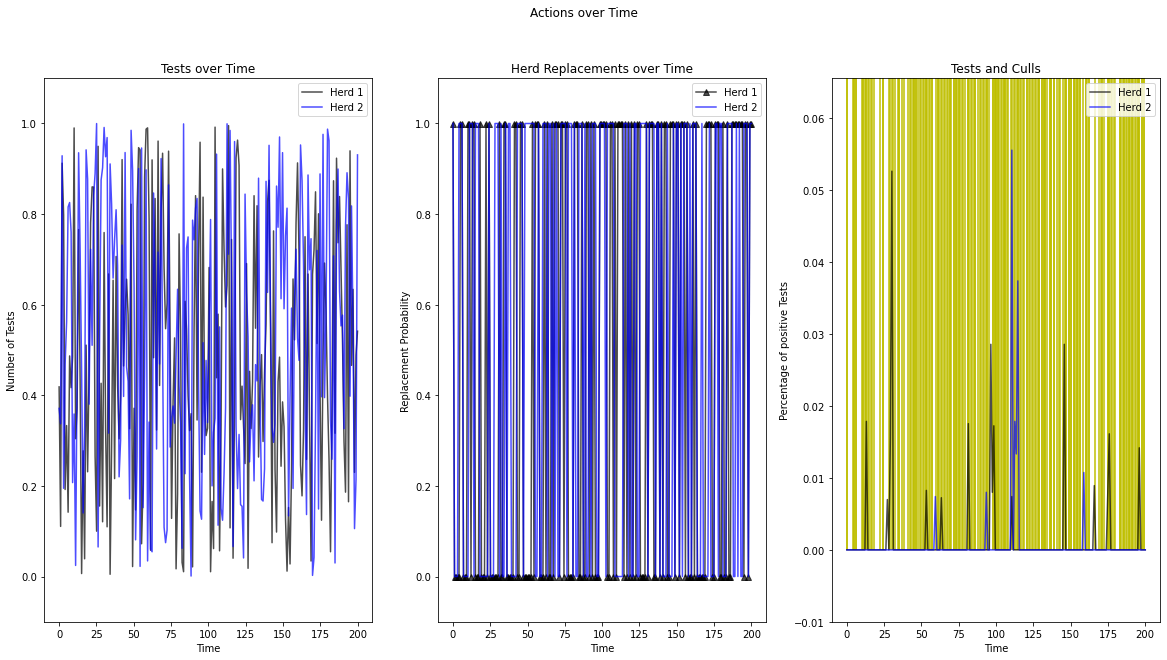

In [9]:
# Testing my pretty function
random_policy = random_tf_policy.RandomTFPolicy(time_step_spec=train_env.time_step_spec(), 
                                                action_spec=train_env.action_spec())
eval_agent(train_env, policy = random_policy, num_episodes= 10, num_herds = 2, create_plot = True)

## Training
In this section, define a function for agent training and evaluation.  
First, create neural networks for use for variations in training.

### RNN DDPG

Set up actor and critic recurrent neural networks for training with DDPG using RNNs.

In [10]:
# RNN hyperparams
actor_fc_layers = (400, 300)
actor_output_fc_layers = (100,)
actor_lstm_size = (40,)
critic_obs_fc_layers = (400,)
critic_action_fc_layers = None
critic_joint_fc_layers = (300,)
critic_output_fc_layers = (100,)
critic_lstm_size = (40,)

# RNN actor critic
actor_rnn = actor_rnn_network.ActorRnnNetwork(train_env.time_step_spec().observation, 
                                              train_env.action_spec(), 
                                              input_fc_layer_params=actor_fc_layers, 
                                              lstm_size = actor_lstm_size, 
                                              output_fc_layer_params=actor_output_fc_layers)

critic_net_input_specs = (train_env.time_step_spec().observation, 
                          train_env.action_spec())

critic_rnn = critic_rnn_network.CriticRnnNetwork(critic_net_input_specs, 
                                                 observation_fc_layer_params=critic_obs_fc_layers, 
                                                 action_fc_layer_params=critic_action_fc_layers, 
                                                 joint_fc_layer_params=critic_joint_fc_layers, 
                                                 lstm_size=critic_lstm_size, 
                                                 output_fc_layer_params=critic_output_fc_layers)

### DDPG  
Create actor and critic artificial neural networks for DDPG.

In [11]:
# Set ann hyperparameters
actor_fc_layers=(400, 300)
critic_obs_fc_layers=(400,)
critic_action_fc_layers=None
critic_joint_fc_layers=(300,)


# Define creation functions 

dense = functools.partial(tf.keras.layers.Dense,
                          activation=tf.keras.activations.relu,
                          kernel_initializer=tf.compat.v1.variance_scaling_initializer(
                              scale=1./ 3.0, mode='fan_in', distribution='uniform')
                         )


def create_identity_layer():
    return tf.keras.layers.Lambda(lambda x: x)


def create_fc_network(layer_units):
    return sequential.Sequential([dense(num_units) for num_units in layer_units])


def create_actor_network(fc_layer_units, action_spec):
    flat_action_spec = tf.nest.flatten(action_spec)
    if len(flat_action_spec) > 1:
        raise ValueError('Only a single action tensor is supported by this network')
    flat_action_spec = flat_action_spec[0]

    fc_layers = [dense(num_units) for num_units in fc_layer_units]

    num_actions = flat_action_spec.shape.num_elements()
    
    action_fc_layer = tf.keras.layers.Dense(num_actions,
                                            activation=tf.keras.activations.tanh,
                                            kernel_initializer=tf.keras.initializers.RandomUniform(
                                                minval=-0.003, maxval=0.003)
                                           )

    scaling_layer = tf.keras.layers.Lambda(
        lambda x: common.scale_to_spec(x, flat_action_spec))
    return sequential.Sequential(fc_layers + [action_fc_layer, scaling_layer])


def create_critic_network(obs_fc_layer_units,
                          action_fc_layer_units,
                          joint_fc_layer_units):
    def split_inputs(inputs):
        return {'observation': inputs[0], 'action': inputs[1]}
    
    if obs_fc_layer_units:
        obs_network = create_fc_network(obs_fc_layer_units)  
    else:
        obs_network = create_identity_layer()
    if action_fc_layer_units:    
        action_network = create_fc_network(action_fc_layer_units)
    else:
        action_network = create_identity_layer()
    if joint_fc_layer_units:    
        joint_network = create_fc_network(joint_fc_layer_units) 
    else: 
        joint_network = create_identity_layer()
    value_fc_layer = tf.keras.layers.Dense(1,
                                           activation=None,
                                           kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)
                                          )

    return sequential.Sequential([tf.keras.layers.Lambda(split_inputs),
                                  nest_map.NestMap({'observation': obs_network,
                                                    'action': action_network}),
                                  nest_map.NestFlatten(),
                                  tf.keras.layers.Concatenate(),
                                  joint_network,
                                  value_fc_layer,
                                  inner_reshape.InnerReshape([1], [])
                                 ])


# Create neural networks

actor_ann = create_actor_network(actor_fc_layers, 
                                 train_env.action_spec())
critic_ann = create_critic_network(critic_obs_fc_layers,
                                   critic_action_fc_layers,
                                   critic_joint_fc_layers)

### Hyperparameters  
Set hyperparameters for DDPG.

In [12]:
num_iterations = 500000

# Agent hyperparameters
actor_learning_rate = 1e-4
critic_learning_rate = 1e-3
ou_stddev = 0.2
ou_damping = 0.15
target_update_tau = 0.05
target_update_period = 5
gamma = 0.995
# Training hyperparameters
train_steps_per_iteration = 10

# Experience replay hyperparameters
rb_capacity = 1000000
batch_size = 64
train_sequence_length = 20    # Automatically set to 1 for ANN DDPG
# For ANN DDPG
collect_steps_per_iteration = 200
initial_collect_steps = 50000
# For RNN DDPG
initial_collect_episodes = 10
collect_episodes_per_iteration = 1


# Evaluation hyperparameters
eval_interval = 1000
plots = True   # Only works if num_herds = 2

### DDPG  
Finally, define training function using tf-agent's ddpg agent.

In [13]:
def DDPG(num_iterations = num_iterations,
         actor_net = None,
         critic_net = None,
         directory = PATH,
         plots = plots,
         eval_interval = eval_interval,
         # Agent hyperparameters
         actor_learning_rate = actor_learning_rate,
         critic_learning_rate = critic_learning_rate,
         ou_stddev = ou_stddev,
         ou_damping = ou_damping,
         target_update_tau = target_update_tau,
         target_update_period = target_update_period,
         gamma = gamma,
         # Training hyperparameters
         train_steps_per_iteration = train_steps_per_iteration,
         # Experience replay hyperparameters
         initial_collect_episodes = initial_collect_episodes,
         collect_episodes_per_iteration = collect_episodes_per_iteration,
         rb_capacity = rb_capacity,
         batch_size = batch_size,
         train_sequence_length = train_sequence_length,
         ):
    
    if actor_net is None or critic_net is None:
        raise ValueError('Please input an actor network and critic network.')
        
    # Global step tracks number of train steps
    global_step = tf.compat.v1.train.get_or_create_global_step()

    # DDPG Agent
    agent = ddpg_agent.DdpgAgent(train_env.time_step_spec(), 
                                 train_env.action_spec(), 
                                 actor_network = actor_net, 
                                 critic_network = critic_net, 
                                 actor_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=actor_learning_rate), 
                                 critic_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=critic_learning_rate), 
                                 ou_stddev = ou_stddev, 
                                 ou_damping = ou_damping, 
                                 target_update_tau = target_update_tau, 
                                 target_update_period = target_update_period,  
                                 gamma = gamma, 
                                 train_step_counter = global_step)
    agent.initialize()
    
    # Tools for evaluation
    eval_policy = agent.policy
    saver = policy_saver.PolicySaver(eval_policy)
    policy_dir = os.path.join(directory, 'policy')
    best_return = -1000000

    # Experience replay and sample collection tools
    collect_policy = agent.collect_policy
    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(agent.collect_data_spec,
                                                                   batch_size=train_env.batch_size,
                                                                   max_length=rb_capacity)
    
    # Assign step drivers to fill replay buffer 
    if isinstance(actor_net, actor_rnn_network.ActorRnnNetwork):
        initial_collect_driver = dynamic_episode_driver.DynamicEpisodeDriver(train_env,
                                                                             collect_policy,
                                                                             observers=[replay_buffer.add_batch],
                                                                             num_episodes=initial_collect_episodes)

        collect_driver = dynamic_episode_driver.DynamicEpisodeDriver(train_env,
                                                                     collect_policy,
                                                                     observers=[replay_buffer.add_batch],
                                                                     num_episodes=collect_episodes_per_iteration)
    else:
        initial_collect_driver = dynamic_step_driver.DynamicStepDriver(train_env,
                                                                       collect_policy,
                                                                       observers=[replay_buffer.add_batch],
                                                                       num_steps=initial_collect_steps)

        collect_driver = dynamic_step_driver.DynamicStepDriver(train_env,
                                                               collect_policy,
                                                               observers=[replay_buffer.add_batch],
                                                               num_steps=collect_steps_per_iteration)
        
    # TF functions speed up training process
    initial_collect_driver.run = common.function(initial_collect_driver.run)
    collect_driver.run = common.function(collect_driver.run)
    agent.train = common.function(agent.train)
    
    # Collect initial random samples for replay buffer
    initial_collect_driver.run()
    
    # Training starts
    time_step = None
    policy_state = collect_policy.get_initial_state(train_env.batch_size)
    
    # If it's an ANN, trajectories have to be two steps long
    if not isinstance(actor_net, actor_rnn_network.ActorRnnNetwork):
        train_sequence_length = 1
        
    dataset = replay_buffer.as_dataset(num_parallel_calls=3,
                                       sample_batch_size=batch_size,
                                       num_steps=train_sequence_length + 1).prefetch(3)
    iterator = iter(dataset)
    
    
    def train_step():
        experience, other_info = next(iterator)
        return agent.train(experience)
    train_step = common.function(train_step)
    
    for _ in range(num_iterations):
        time_step, policy_state = collect_driver.run(time_step=time_step,
                                                     policy_state=policy_state)    
        for _ in range(train_steps_per_iteration):
            train_loss = train_step()
        
        # Evaluation
        if global_step.numpy() % eval_interval == 0:
            average_return, culls, tests = eval_agent(eval_env, eval_policy, num_episodes=200, create_plot = plots)
            print('Global Step = {0}, Average Return = {1:.1f}.'.format(global_step.numpy(), average_return.numpy().item()))
            print('Average Culls = {0}, Average Tests = {1}.'.format(culls, tests))                    
            if average_return > best_return:
                best_return = average_return
                print('New best return: ', best_return)
                saver.save(os.path.join(policy_dir, str(global_step.numpy())))
    return train_loss

# Run Functions (rename)  
Now you can execute ddpg using either artificial or recurrent NNs!

In [ ]:
loss = DDPG(num_iterations = num_iterations,
            actor_net = actor_ann,
            critic_net = critic_ann,
            directory = PATH,
            plots = plots,
            eval_interval = eval_interval,
            # Agent hyperparameters
            actor_learning_rate = actor_learning_rate,
            critic_learning_rate = critic_learning_rate,
            ou_stddev = ou_stddev,
            ou_damping = ou_damping,
            target_update_tau = target_update_tau,
            target_update_period = target_update_period,
            gamma = gamma,
            # Experience replay hyperparameters
            initial_collect_episodes = initial_collect_episodes,
            collect_episodes_per_iteration = collect_episodes_per_iteration,
            rb_capacity = rb_capacity,
            batch_size = batch_size,
            train_sequence_length = train_sequence_length)